In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset

In [31]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mnist data load
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# PyTorch Tensor reshape
x_train_tensor = torch.tensor(x_train).unsqueeze(1)  # (N, 1, 28, 28)
x_test_tensor = torch.tensor(x_test).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader create
batch_size = 128
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=batch_size)

In [32]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [33]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
# Training loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Testing loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train and evaluate
for epoch in range(1, 6):
    train(epoch)
    test()

Test set: Average loss: 0.0009, Accuracy: 96.27%
Test set: Average loss: 0.0007, Accuracy: 97.27%
Test set: Average loss: 0.0006, Accuracy: 97.70%
Test set: Average loss: 0.0005, Accuracy: 97.74%
Test set: Average loss: 0.0005, Accuracy: 97.96%


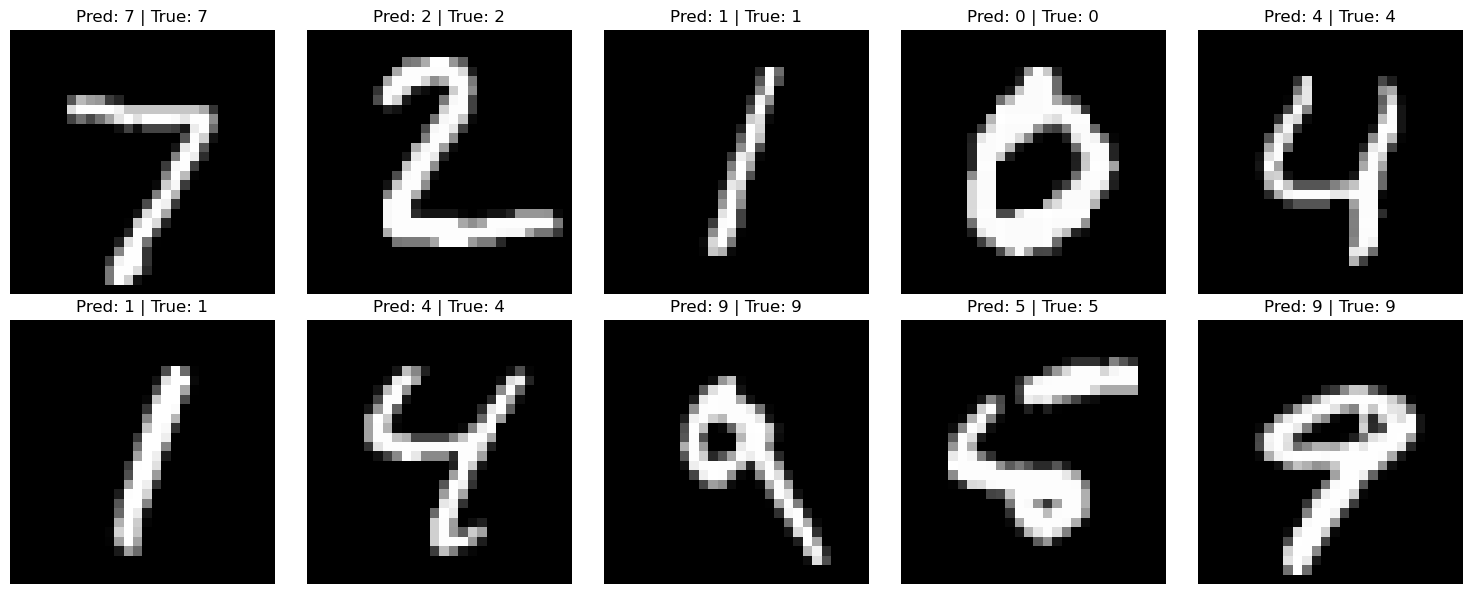

In [35]:
# Visualize predictions
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
with torch.no_grad():
    for i in range(10):
        image, label = test_dataset[i]
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
        axes[i//5, i%5].imshow(image.squeeze(), cmap='gray')
        axes[i//5, i%5].set_title(f'Pred: {pred} | True: {label}')
        axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()